Candidate Assessment - Advanced ECG Analysis and Deep Learning

Part 1: Dataset Exploration and Baseline Analysis (25 points)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd "/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model/"

/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

Load data

In [ ]:
# --- Load Data ---
path = './'

df = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)

agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)

Sample Size

In [ ]:
sample_size = len(df)
print(f"Sample Size: {sample_size}")

Sample Size: 21799


Plot demographic distribution

In [ ]:
def plot_age_distribution(df):

    plt.figure(figsize=(10, 6))
    sns.histplot(df['age'], bins=30, kde=True)
    plt.title('Age Distribution of Patients')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    plt.close()

In [ ]:
def plot_sex_distribution(df):

    plt.figure(figsize=(8, 5))
    sex_labels = df['sex'].map({0: 'Male', 1: 'Female'})
    sns.countplot(x=sex_labels)
    plt.title('Sex Distribution of Patients')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.show()
    plt.close()

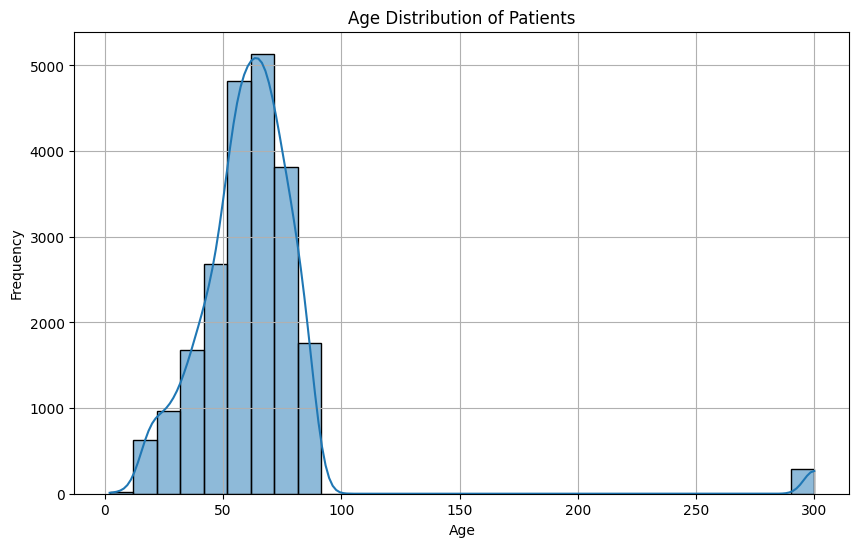

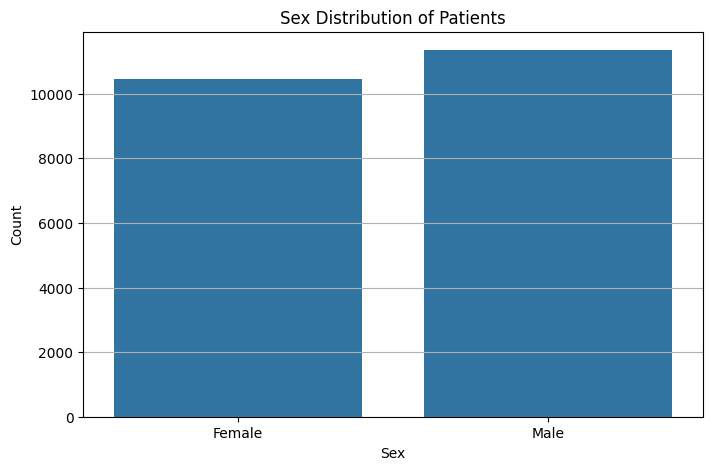

In [ ]:
plot_age_distribution(df.copy())

plot_sex_distribution(df.copy())

Recording parameters

Available Sampling Rates: 100 Hz (Low Resolution), 500 Hz (High Resolution)

Recording Device Distribution:
device
CS100    3    6140
CS-12         4048
AT-6 C 5.5    3950
CS-12   E     2878
AT-6     6    2273
AT-60    3     966
AT-6 C 5.8     824
AT-6 C         514
AT-6 C 5.0      80
AT-6 C 5.3      67
AT-6 C 5.6      59
Name: count, dtype: int64


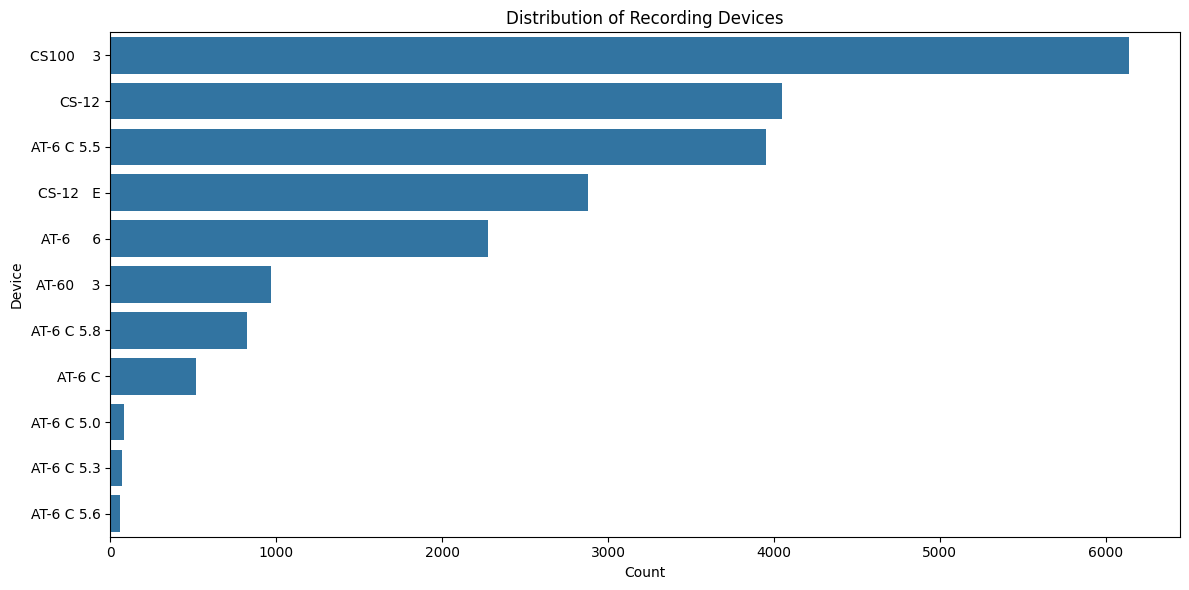

In [ ]:
sampling_rates = []
if 'filename_lr' in df.columns:
    sampling_rates.append('100 Hz (Low Resolution)')
if 'filename_hr' in df.columns:
    sampling_rates.append('500 Hz (High Resolution)')

print(f"Available Sampling Rates: {', '.join(sampling_rates)}")

# Device
print("\nRecording Device Distribution:")
print(df['device'].value_counts())

# Plot device distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='device', data=df, order=df['device'].value_counts().index)
plt.title('Distribution of Recording Devices')
plt.xlabel('Count')
plt.ylabel('Device')
plt.tight_layout()
plt.show()
plt.close()

Plot class distribution

In [ ]:
def plot_diagnostic_superclass_distribution(df):

    plt.figure(figsize=(12, 7))
    sns.countplot(y='diagnostic_superclass', data=df, order=df['diagnostic_superclass'].value_counts().index)
    plt.title('Distribution of Diagnostic Superclasses')
    plt.xlabel('Count')
    plt.ylabel('Diagnostic Superclass')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
df['diagnostic_superclass']

,diagnostic_superclass
ecg_id,
1,[NORM]
2,[NORM]
3,[NORM]
4,[NORM]
5,[NORM]
...,...
21833,[STTC]
21834,[NORM]
21835,[STTC]


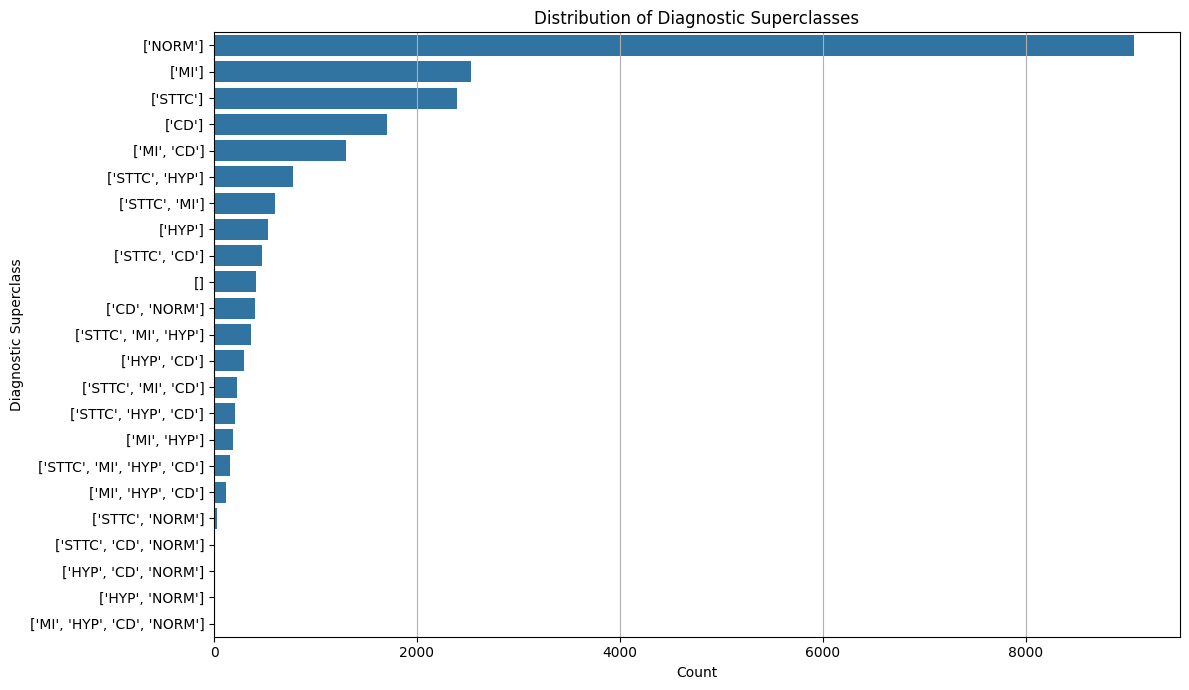

In [ ]:
plot_diagnostic_superclass_distribution(df.copy())

In [ ]:
empty_count = df['diagnostic_superclass'].apply(lambda x: len(x) == 0).sum()
print(f"Number of patients with empty diagnosis: {empty_count}")

Number of patients with empty diagnosis: 411


In [ ]:
# Returns the number of rows where the list is exactly ['NORM']
exact_norm_count = df['diagnostic_superclass'].apply(lambda x: x == ['NORM']).sum()

print(f"Patients with ONLY NORM: {exact_norm_count}")

Patients with ONLY NORM: 9069


ECG quality assessment

In [ ]:
def analyze_data_quality(df):
    # 1. Missing Data Analysis
    print("1. Missing Data Analysis")

    standard_nulls = df.isnull().sum()

    empty_lists = pd.Series(0, index=df.columns)
    for col in df.select_dtypes(include=['object']):
        # Count rows where the value is a list AND has length 0
        empty_lists[col] = df[col].apply(
            lambda x: isinstance(x, list) and len(x) == 0
        ).sum()

    total_missing = standard_nulls + empty_lists
    missing_percentages = (total_missing / len(df)) * 100

    missing_data = pd.DataFrame({
        'Total Missing': total_missing,
        'Percentage': missing_percentages
    })

    missing_data = missing_data[missing_data['Total Missing'] > 0].sort_values(by='Percentage', ascending=False)

    if not missing_data.empty:
        print(missing_data)
    else:
        print("No missing data (nulls or empty lists) found.")
    print("-" * 30)


    # 2. Noise Level Analysis
    print("2. Noise & Quality Indicators")

    noise_columns = [
        'baseline_drift',
        'static_noise',
        'burst_noise',
        'electrodes_problems',
        'extra_beats',
        'pacemaker'
    ]

    for col in noise_columns:
        non_null_count = df[col].count()
        percentage = (non_null_count / len(df)) * 100
        print(f"Records with {col}: {non_null_count} ({percentage:.2f}%)")

In [ ]:
analyze_data_quality(df.copy())

1. Missing Data Analysis
                       Total Missing  Percentage
electrodes_problems            21769   99.862379
infarction_stadium2            21696   99.527501
pacemaker                      21508   98.665076
burst_noise                    21186   97.187944
baseline_drift                 20201   92.669389
extra_beats                    19850   91.059223
static_noise                   18539   85.045186
infarction_stadium1            16187   74.255700
height                         14825   68.007707
weight                         12378   56.782421
validated_by                    9378   43.020322
heart_axis                      8468   38.845819
nurse                           1473    6.757191
diagnostic_superclass            411    1.885408
site                              17    0.077985
------------------------------
2. Noise & Quality Indicators
Records with baseline_drift: 1598 (7.33%)
Records with static_noise: 3260 (14.95%)
Records with burst_noise: 613 (2.81%)
Records w

Part 2: Multi-Lead ECG Autoencoder with Embedding Aggregation

Data split and save in .npy format

In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]

    data = np.array([signal for signal, meta in data])
    return data

path = './'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
#print(X)
print(X.shape)
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold))]
print(X_train.shape)
#Validation
X_val = X[np.where(Y.strat_fold == val_fold)]
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]

# Save with path
np.save('data/X_train.npy', X_train)
np.save('data/X_validation.npy', X_val)
np.save('data/X_test.npy', X_test)

(21799, 5000, 12)
(15245, 5000, 12)


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd "/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model/"

/content/drive/MyDrive/2026_applications/Sorbonne-foundation-model


In [3]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 14.7 MB/s eta 0:00:00


In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy import signal
from numba import jit, prange
from torch.autograd import Function
from numba import cuda
import math
import torch.cuda
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
from scipy.stats import pearsonr
import neurokit2 as nk
import argparse
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

Preprocessing

In [5]:
def normalization(Z):
    mini=Z.min()
    maxi=Z.max()
    return(-1+((Z-mini)*(2))/(maxi-mini))

def filtering(Z):
    mini=Z.min()
    maxi=Z.max()
    signal_bef = np.zeros((len(Z[:])))
    temp = (-1+((Z-mini)*(2))/(maxi-mini))
    signal_bef = temp
    nyquist = 0.5 * 500
    low_cutoff = 0.05 / nyquist
    high_cutoff = 150.0 / nyquist
    new_sampling_frequency = 512
    original_sampling_frequency = 5000
    b, a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
    filtered_signal = signal.lfilter(b, a, signal_bef)
    filtered_signal = signal_bef
    resampled_signal = normalization(signal.resample(filtered_signal, int(len(filtered_signal) * (new_sampling_frequency / original_sampling_frequency))))
    if np.all(np.isnan(resampled_signal)):
        resampled_signal = np.random.normal(0,1,(512))
    return(resampled_signal)


def define_possibility(data):
    P = []
    L = []
    for i in range(1,12):
        if 12%i == 0:
            sous_P = []
            sous_L = []
            for j in range(0,12,i):
                sous_L.append(j)
            L.append(sous_L)
            for j in range(0,len(data[0])+1, int(len(data[0]) / (12 / i))):
                sous_P.append(j)
            sous_P[-1] = 512
            P.append(sous_P)
    return(L,P)

def masking(signal, L, P):
    full_cut_signal = []
    full_full_signal =[]
    for p in range(len(P)):
        cut_signal = np.random.random(signal.shape)
        itp = 0
        it = 0
        for l in range(12):
            try:
                if L[p][it] <= l < L[p][it+1]:
                    pass
                else:
                    itp += 1
                    it  +=1
            except IndexError:
                pass
            cut_signal[P[p][itp]:P[p][itp+1],l] = signal[P[p][itp]:P[p][itp+1],l]
            signal[:,l] = signal[:,l]
        full_cut_signal.append(np.array(cut_signal))
        full_full_signal.append(signal)

    for i in range(12):
        cut_signal = np.random.random(signal.shape)
        cut_signal[:,i] = signal[:,i]
        full_cut_signal.append(np.array(cut_signal))
        full_full_signal.append(signal)
    full_cut_signal = np.array(full_cut_signal)
    full_full_signal = np.array(full_full_signal)
    return(full_cut_signal, full_full_signal)

def creat_dataset(data):
    cut_data = []
    full_data = []
    L,P = define_possibility(data)
    for i in tqdm(range(len(data))):
        cut, full = masking(data[i], L,P)
        cut_data.append(cut)
        full_data.append(full)
    cut_data = np.array(cut_data)
    full_data = np.array(full_data)
    return(np.concatenate(cut_data,0), np.concatenate(full_data,0))


def pre_processing(path, seed):
    data = np.load(path)
    new_data = np.zeros((len(data),512,12))
    for i in tqdm(range(len(data))):
        for l in range(12):
            new_data[i,:,l] = filtering(data[i,:,l])
    data_mask, data_true = creat_dataset(new_data)
    np.random.seed(seed)
    np.random.shuffle(data_mask)
    np.random.seed(seed)
    np.random.shuffle(data_true)
    return(data_mask, data_true)

Load model

In [6]:
class Convolution1D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Convolution1D_layer, self).__init__()
        self.f = out_f
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_f, out_channels=out_f, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm1d(num_features=out_f),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.2)
        )


    def forward(self, x, device):
        b = len(x)
        new_x = torch.tensor(np.zeros((b,self.f, 12, int(x.shape[-1]/2))).astype("float32")).to(device)
        for i in range(12):
            new_x[:,:,i,:] = self.conv(x[:,:,i,:])
        return(new_x)


class Deconvolution1D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Deconvolution1D_layer, self).__init__()
        self.f = out_f
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=in_f, out_channels=out_f, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm1d(num_features=out_f),
            nn.LeakyReLU(0.02),
            nn.Dropout(0.2)
        )


    def forward(self, x, device):
        b = len(x)
        new_x = torch.tensor(np.zeros((b,self.f, 12, int(x.shape[-1]*2))).astype("float32")).to(device)
        for i in range(12):
            new_x[:,:,i,:] = self.deconv(x[:,:,i,:])
        return(new_x)

class Convolution2D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Convolution2D_layer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_f, out_channels=out_f, kernel_size = (13,4), stride = (1,2), padding = (6,1)),
            nn.BatchNorm2d(num_features=out_f),
            nn.LeakyReLU(0.02),
            #nn.Dropout(0.2)
        )


    def forward(self, x):
        new_x = self.conv(x)
        return(new_x)


class Deconvolution2D_layer(nn.Module):
    def __init__(self, in_f, out_f):
        super(Deconvolution2D_layer, self).__init__()
        self.f = out_f
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_f, out_channels=out_f, kernel_size = (13,4), stride = (1,2), padding = (6,1)),
            nn.BatchNorm2d(num_features=out_f),
            nn.LeakyReLU(0.02),
            #nn.Dropout(0.2)
        )


    def forward(self, x):
        new_x = self.deconv(x)
        return(new_x)



class Autoencoder_net(nn.Module):
    def __init__(self):
        super(Autoencoder_net, self).__init__()
        self.first_conv2D = Convolution2D_layer(1,16)
        self.first_conv1D = Convolution1D_layer(1,16)

        self.second_conv2D = Convolution2D_layer(16,32)
        self.second_conv1D = Convolution1D_layer(16,32)

        self.third_conv2D = Convolution2D_layer(32,64)
        self.third_conv1D = Convolution1D_layer(32,64)

        self.fourth_conv2D = Convolution2D_layer(64,128)
        self.fourth_conv1D = Convolution1D_layer(64,128)

        self.first_deconv1D = Deconvolution1D_layer(256,128)
        self.first_deconv2D = Deconvolution2D_layer(256,128)

        self.second_deconv1D = Deconvolution1D_layer(256,64)
        self.second_deconv2D = Deconvolution2D_layer(256,64)

        self.third_deconv1D = Deconvolution1D_layer(128,32)
        self.third_deconv2D = Deconvolution2D_layer(128,32)

        self.fourth_deconv1D = Deconvolution1D_layer(64,1)
        self.fourth_deconv2D = Deconvolution2D_layer(64,1)

        self.final_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size = (13,3), stride = (1,1), padding = (6,1)),
            nn.Tanh(),
        )

        self.transition_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size = (13,3), stride = (1,1), padding = (6,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.02)
        )



    def forward(self, x, device):
        conv2D_1 = self.first_conv2D(x)
        conv1D_1 = self.first_conv1D(x, device)
        conv_1 = torch.concat((conv1D_1,conv2D_1),axis = 1)
        #print("Conv1: ",conv1D_1.shape)
        #print("Conv1: ",conv2D_1.shape)

        conv2D_2 = self.second_conv2D(conv2D_1)
        conv1D_2 = self.second_conv1D(conv1D_1,device)
        #print("Conv2: ",conv1D_2.shape)
        #print("Conv2: ",conv2D_2.shape)
        conv_2 = torch.concat((conv1D_2,conv2D_2),axis = 1)
        #print("Conv2: ",conv_2.shape)

        conv2D_3 = self.third_conv2D(conv2D_2)
        conv1D_3 = self.third_conv1D(conv1D_2,device)
        #print("Conv3: ",conv1D_3.shape)
        #print("Conv3: ",conv2D_3.shape)
        conv_3 = torch.concat((conv1D_3,conv2D_3),axis = 1)
        #print("Conv3: ",conv_3.shape)

        conv2D_4 = self.fourth_conv2D(conv2D_3)
        conv1D_4 = self.fourth_conv1D(conv1D_3,device)
        #print("Conv4: ",conv1D_4.shape)
        #print("Conv4: ",conv2D_4.shape)
        conv_4 = torch.concat((conv1D_4,conv2D_4),axis = 1)
        #print("Conv4: ",conv_4.shape)

        transition = self.transition_block(conv_4)
        #print("Transition: ", transition.shape)


        deconv2D_1 = self.first_deconv2D(conv_4)
        #print("Deconv 1: ",deconv2D_1.shape)
        deconv_1 = torch.concat((deconv2D_1,conv_3),axis = 1)
        #print("Deconv 1 Concat: ",deconv_1.shape)


        deconv2D_2 = self.second_deconv2D(deconv_1)
        #print("Deconv 2: ",deconv2D_2.shape)
        deconv_2 = torch.concat((deconv2D_2,conv_2),axis = 1)
        #print("Deconv 2 Concat: ",deconv_2.shape)

        deconv2D_3 = self.third_deconv2D(deconv_2)
        #print("Deconv 3: ",deconv2D_3.shape)
        deconv_3 = torch.concat((deconv2D_3,conv_1),axis = 1)
        #print("Deconv 3 Concat: ",deconv_3.shape)

        deconv2D_4 = self.fourth_deconv2D(deconv_3)
        #print("Deconv 4: ",deconv2D_4.shape)

        out = self.final_conv(deconv2D_4)
        out = torch.squeeze(out,1)
        return(out)



def load_model():
    Autoencoder = Autoencoder_net()
    return(Autoencoder)

Complete data

In [7]:
def Complete_data(data,Autoencoder,device):
    batch_size = 256
    regenerate_lead = []

    for b in range(0,len(data),batch_size):
        r = data[b:b+batch_size,:,:]
        r = np.expand_dims(r,1).astype("float32")
        r = torch.tensor(r).to(device)
        r = Autoencoder(r, device).to('cpu').detach().numpy()[:,:,:]
        regenerate_lead.append(r)
    regenerate_lead = np.array(np.concatenate(regenerate_lead))
    return(regenerate_lead)

Loss function

In [8]:
class RMSE_Loss(torch.nn.Module):
    def __init__(self, alpha=1):
        super(RMSE_Loss, self).__init__()

    def forward(self, y_true, y_pred):
        loss1 = torch.mean(torch.square(y_true - y_pred), axis = 2)
        loss1= torch.nan_to_num(loss1)
        loss2 = pearson_correlation(y_true, y_pred)
        loss = loss1 - (0.1*loss2)
        return(torch.mean(torch.mean(loss,axis =1)), torch.mean(loss2), torch.mean(loss1))
RMSELoss = RMSE_Loss()

def pearson_correlation(x,y):
    # Ensure that x and y are the same length
    assert len(x) == len(y)

    # Calculate the means of x and y
    x_mean = torch.mean(x, axis = 2)
    y_mean = torch.mean(y, axis = 2)

    # Calculate the variance of x and y
    x_variance = torch.var(x, axis = 2)
    y_variance = torch.var(y, axis = 2)

    # Calculate the standard deviations of x and y
    x_stddev = torch.sqrt(x_variance)
    y_stddev = torch.sqrt(y_variance)



    # Calculate the Pearson correlation coefficient
    r = torch.sum((x - torch.unsqueeze(x_mean, 2)) * (y - torch.unsqueeze(y_mean, 2)), axis = 2 )
    r = r/((len(x[0][0]) * x_stddev * y_stddev))
    r = torch.nan_to_num(r)

    return r


class loss_function(torch.nn.Module):
    def __init__(self, alpha=1):
        super(loss_function, self).__init__()

    def forward(self, y_true, y_pred):
        # Calculate the MSE
        loss1 = torch.mean(torch.square(y_true - y_pred), axis = 2)

        # Calculate the mean correlation of an ECG
        loss2 = pearson_correlation(y_true, y_pred)

        # Calculate the loss
        loss = loss1 - (0.1*loss2)

        # Return the loss, the pearson correlation and the MSE
        return(torch.mean(torch.mean(loss,axis =1)), torch.mean(loss2), torch.mean(loss1))

SoftDTW_functions

In [9]:
# ----------------------------------------------------------------------------------------------------------------------
@cuda.jit
def compute_softdtw_cuda(D, gamma, bandwidth, max_i, max_j, n_passes, R):
    """
    :param seq_len: The length of the sequence (both inputs are assumed to be of the same size)
    :param n_passes: 2 * seq_len - 1 (The number of anti-diagonals)
    """
    # Each block processes one pair of examples
    b = cuda.blockIdx.x
    # We have as many threads as seq_len, because the most number of threads we need
    # is equal to the number of elements on the largest anti-diagonal
    tid = cuda.threadIdx.x

    # Compute I, J, the indices from [0, seq_len)

    # The row index is always the same as tid
    I = tid

    inv_gamma = 1.0 / gamma

    # Go over each anti-diagonal. Only process threads that fall on the current on the anti-diagonal
    for p in range(n_passes):

        # The index is actually 'p - tid' but need to force it in-bounds
        J = max(0, min(p - tid, max_j - 1))

        # For simplicity, we define i, j which start from 1 (offset from I, J)
        i = I + 1
        j = J + 1

        # Only compute if element[i, j] is on the current anti-diagonal, and also is within bounds
        if I + J == p and (I < max_i and J < max_j):
            # Don't compute if outside bandwidth
            if not (abs(i - j) > bandwidth > 0):
                r0 = -R[b, i - 1, j - 1] * inv_gamma
                r1 = -R[b, i - 1, j] * inv_gamma
                r2 = -R[b, i, j - 1] * inv_gamma
                rmax = max(max(r0, r1), r2)
                rsum = math.exp(r0 - rmax) + math.exp(r1 - rmax) + math.exp(r2 - rmax)
                softmin = -gamma * (math.log(rsum) + rmax)
                R[b, i, j] = D[b, i - 1, j - 1] + softmin

        # Wait for other threads in this block
        cuda.syncthreads()

# ----------------------------------------------------------------------------------------------------------------------
@cuda.jit
def compute_softdtw_backward_cuda(D, R, inv_gamma, bandwidth, max_i, max_j, n_passes, E):
    k = cuda.blockIdx.x
    tid = cuda.threadIdx.x

    # Indexing logic is the same as above, however, the anti-diagonal needs to
    # progress backwards
    I = tid

    for p in range(n_passes):
        # Reverse the order to make the loop go backward
        rev_p = n_passes - p - 1

        # convert tid to I, J, then i, j
        J = max(0, min(rev_p - tid, max_j - 1))

        i = I + 1
        j = J + 1

        # Only compute if element[i, j] is on the current anti-diagonal, and also is within bounds
        if I + J == rev_p and (I < max_i and J < max_j):

            if math.isinf(R[k, i, j]):
                R[k, i, j] = -math.inf

            # Don't compute if outside bandwidth
            if not (abs(i - j) > bandwidth > 0):
                a = math.exp((R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) * inv_gamma)
                b = math.exp((R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) * inv_gamma)
                c = math.exp((R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) * inv_gamma)
                E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c

        # Wait for other threads in this block
        cuda.syncthreads()

# ----------------------------------------------------------------------------------------------------------------------
class _SoftDTWCUDA(Function):
    """
    CUDA implementation is inspired by the diagonal one proposed in https://ieeexplore.ieee.org/document/8400444:
    "Developing a pattern discovery method in time series data and its GPU acceleration"
    """

    @staticmethod
    def forward(ctx, D, gamma, bandwidth):
        dev = D.device
        dtype = D.dtype
        gamma = torch.cuda.FloatTensor([gamma])
        bandwidth = torch.cuda.FloatTensor([bandwidth])

        B = D.shape[0]
        N = D.shape[1]
        M = D.shape[2]
        threads_per_block = max(N, M)
        n_passes = 2 * threads_per_block - 1

        # Prepare the output array
        R = torch.ones((B, N + 2, M + 2), device=dev, dtype=dtype) * math.inf
        R[:, 0, 0] = 0

        # Run the CUDA kernel.
        # Set CUDA's grid size to be equal to the batch size (every CUDA block processes one sample pair)
        # Set the CUDA block size to be equal to the length of the longer sequence (equal to the size of the largest diagonal)
        compute_softdtw_cuda[B, threads_per_block](cuda.as_cuda_array(D.detach()),
                                                   gamma.item(), bandwidth.item(), N, M, n_passes,
                                                   cuda.as_cuda_array(R))
        ctx.save_for_backward(D, R.clone(), gamma, bandwidth)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma, bandwidth = ctx.saved_tensors

        B = D.shape[0]
        N = D.shape[1]
        M = D.shape[2]
        threads_per_block = max(N, M)
        n_passes = 2 * threads_per_block - 1

        D_ = torch.zeros((B, N + 2, M + 2), dtype=dtype, device=dev)
        D_[:, 1:N + 1, 1:M + 1] = D

        R[:, :, -1] = -math.inf
        R[:, -1, :] = -math.inf
        R[:, -1, -1] = R[:, -2, -2]

        E = torch.zeros((B, N + 2, M + 2), dtype=dtype, device=dev)
        E[:, -1, -1] = 1

        # Grid and block sizes are set same as done above for the forward() call
        compute_softdtw_backward_cuda[B, threads_per_block](cuda.as_cuda_array(D_),
                                                            cuda.as_cuda_array(R),
                                                            1.0 / gamma.item(), bandwidth.item(), N, M, n_passes,
                                                            cuda.as_cuda_array(E))
        E = E[:, 1:N + 1, 1:M + 1]
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None


# ----------------------------------------------------------------------------------------------------------------------
#
# The following is the CPU implementation based on https://github.com/Sleepwalking/pytorch-softdtw
# Credit goes to Kanru Hua.
# I've added support for batching and pruning.
#
# ----------------------------------------------------------------------------------------------------------------------
@jit(nopython=True, parallel=True)
def compute_softdtw(D, gamma, bandwidth):
    B = D.shape[0]
    N = D.shape[1]
    M = D.shape[2]
    R = np.ones((B, N + 2, M + 2)) * np.inf
    R[:, 0, 0] = 0
    for b in prange(B):
        for j in range(1, M + 1):
            for i in range(1, N + 1):

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                r0 = -R[b, i - 1, j - 1] / gamma
                r1 = -R[b, i - 1, j] / gamma
                r2 = -R[b, i, j - 1] / gamma
                rmax = max(max(r0, r1), r2)
                rsum = np.exp(r0 - rmax) + np.exp(r1 - rmax) + np.exp(r2 - rmax)
                softmin = - gamma * (np.log(rsum) + rmax)
                R[b, i, j] = D[b, i - 1, j - 1] + softmin
    return R

# ----------------------------------------------------------------------------------------------------------------------
@jit(nopython=True, parallel=True)
def compute_softdtw_backward(D_, R, gamma, bandwidth):
    B = D_.shape[0]
    N = D_.shape[1]
    M = D_.shape[2]
    D = np.zeros((B, N + 2, M + 2))
    E = np.zeros((B, N + 2, M + 2))
    D[:, 1:N + 1, 1:M + 1] = D_
    E[:, -1, -1] = 1
    R[:, :, -1] = -np.inf
    R[:, -1, :] = -np.inf
    R[:, -1, -1] = R[:, -2, -2]
    for k in prange(B):
        for j in range(M, 0, -1):
            for i in range(N, 0, -1):

                if np.isinf(R[k, i, j]):
                    R[k, i, j] = -np.inf

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                a0 = (R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) / gamma
                b0 = (R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) / gamma
                c0 = (R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) / gamma
                a = np.exp(a0)
                b = np.exp(b0)
                c = np.exp(c0)
                E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c
    return E[:, 1:N + 1, 1:M + 1]

# ----------------------------------------------------------------------------------------------------------------------
class _SoftDTW(Function):
    """
    CPU implementation based on https://github.com/Sleepwalking/pytorch-softdtw
    """

    @staticmethod
    def forward(ctx, D, gamma, bandwidth):
        dev = D.device
        dtype = D.dtype
        gamma = torch.Tensor([gamma]).to(dev).type(dtype)  # dtype fixed
        bandwidth = torch.Tensor([bandwidth]).to(dev).type(dtype)
        D_ = D.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        R = torch.Tensor(compute_softdtw(D_, g_, b_)).to(dev).type(dtype)
        ctx.save_for_backward(D, R, gamma, bandwidth)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma, bandwidth = ctx.saved_tensors
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        E = torch.Tensor(compute_softdtw_backward(D_, R_, g_, b_)).to(dev).type(dtype)
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None

# ----------------------------------------------------------------------------------------------------------------------
class SoftDTW(torch.nn.Module):
    """
    The soft DTW implementation that optionally supports CUDA
    """

    def __init__(self, use_cuda, gamma=1.0, normalize=False, bandwidth=None, dist_func=None):
        """
        Initializes a new instance using the supplied parameters
        :param use_cuda: Flag indicating whether the CUDA implementation should be used
        :param gamma: sDTW's gamma parameter
        :param normalize: Flag indicating whether to perform normalization
                          (as discussed in https://github.com/mblondel/soft-dtw/issues/10#issuecomment-383564790)
        :param bandwidth: Sakoe-Chiba bandwidth for pruning. Passing 'None' will disable pruning.
        :param dist_func: Optional point-wise distance function to use. If 'None', then a default Euclidean distance function will be used.
        """
        super(SoftDTW, self).__init__()
        self.normalize = normalize
        self.gamma = gamma
        self.bandwidth = 0 if bandwidth is None else float(bandwidth)
        self.use_cuda = use_cuda

        # Set the distance function
        if dist_func is not None:
            self.dist_func = dist_func
        else:
            self.dist_func = SoftDTW._euclidean_dist_func

    def _get_func_dtw(self, x, y):
        """
        Checks the inputs and selects the proper implementation to use.
        """
        bx, lx, dx = x.shape
        by, ly, dy = y.shape
        # Make sure the dimensions match
        assert bx == by  # Equal batch sizes
        assert dx == dy  # Equal feature dimensions

        use_cuda = self.use_cuda

        if use_cuda and (lx > 1024 or ly > 1024):  # We should be able to spawn enough threads in CUDA
                print("SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)")
                use_cuda = False

        # Finally, return the correct function
        return _SoftDTWCUDA.apply if use_cuda else _SoftDTW.apply

    @staticmethod
    def _euclidean_dist_func(x, y):
        """
        Calculates the Euclidean distance between each element in x and y per timestep
        """
        n = x.size(1)
        m = y.size(1)
        d = x.size(2)
        x = x.unsqueeze(2).expand(-1, n, m, d)
        y = y.unsqueeze(1).expand(-1, n, m, d)
        return torch.pow(x - y, 2).sum(3)

    def forward(self, X, Y):
        """
        Compute the soft-DTW value between X and Y
        :param X: One batch of examples, batch_size x seq_len x dims
        :param Y: The other batch of examples, batch_size x seq_len x dims
        :return: The computed results
        """

        # Check the inputs and get the correct implementation
        func_dtw = self._get_func_dtw(X, Y)

        if self.normalize:
            # Stack everything up and run
            x = torch.cat([X, X, Y])
            y = torch.cat([Y, X, Y])
            D = self.dist_func(x, y)
            out = func_dtw(D, self.gamma, self.bandwidth)
            out_xy, out_xx, out_yy = torch.split(out, X.shape[0])
            return out_xy - 1 / 2 * (out_xx + out_yy)
        else:
            D_xy = self.dist_func(X, Y)
            return func_dtw(D_xy, self.gamma, self.bandwidth)

# ----------------------------------------------------------------------------------------------------------------------
def timed_run(a, b, sdtw):
    """
    Runs a and b through sdtw, and times the forward and backward passes.
    Assumes that a requires gradients.
    :return: timing, forward result, backward result
    """
    from timeit import default_timer as timer

    # Forward pass
    start = timer()
    forward = sdtw(a, b)
    end = timer()
    t = end - start

    grad_outputs = torch.ones_like(forward)

    # Backward
    start = timer()
    grads = torch.autograd.grad(forward, a, grad_outputs=grad_outputs)[0]
    end = timer()

    # Total time
    t += end - start

    return t, forward, grads

# ----------------------------------------------------------------------------------------------------------------------
def profile(batch_size, seq_len_a, seq_len_b, dims, tol_backward):
    sdtw = SoftDTW(False, gamma=1.0, normalize=False)
    sdtw_cuda = SoftDTW(True, gamma=1.0, normalize=False)
    n_iters = 6

    print("Profiling forward() + backward() times for batch_size={}, seq_len_a={}, seq_len_b={}, dims={}...".format(batch_size, seq_len_a, seq_len_b, dims))

    times_cpu = []
    times_gpu = []

    for i in range(n_iters):
        a_cpu = torch.rand((batch_size, seq_len_a, dims), requires_grad=True)
        b_cpu = torch.rand((batch_size, seq_len_b, dims))
        a_gpu = a_cpu.cuda()
        b_gpu = b_cpu.cuda()

        # GPU
        t_gpu, forward_gpu, backward_gpu = timed_run(a_gpu, b_gpu, sdtw_cuda)

        # CPU
        t_cpu, forward_cpu, backward_cpu = timed_run(a_cpu, b_cpu, sdtw)

        # Verify the results
        assert torch.allclose(forward_cpu, forward_gpu.cpu())
        assert torch.allclose(backward_cpu, backward_gpu.cpu(), atol=tol_backward)

        if i > 0:  # Ignore the first time we run, in case this is a cold start (because timings are off at a cold start of the script)
            times_cpu += [t_cpu]
            times_gpu += [t_gpu]

    # Average and log
    avg_cpu = np.mean(times_cpu)
    avg_gpu = np.mean(times_gpu)
    print("  CPU:     ", avg_cpu)
    print("  GPU:     ", avg_gpu)
    print("  Speedup: ", avg_cpu / avg_gpu)
    print()

Compute metrics

In [10]:
def MAE(x,y):
    MAE = np.mean(np.absolute(x - y))
    return(MAE)
def RMSE(x,y):
    RMSE = np.sqrt(np.mean((x-y)**2))
    return(RMSE)

def cut_lead(r,t,lead, config):
    list_config = np.array([[[0,42],[42,84],[84,126],[126,168],[168,210],[210,252],[252,294],[294,336],[336,378],[378,420],[420,462],[462,512]],
                  [[0,85],[0,85],[85,170],[85,170],[170,255],[170,255],[255,340],[255,340],[340,425],[340,425],[425,512],[425,512]],
                  [[0,128],[0,128],[0,128],[128,256],[128,256],[128,256],[256,384],[256,384],[256,384],[384,512],[384,512],[384,512]],
                  [[0,170],[0,170],[0,170],[0,170],[170,340],[170,340],[170,340],[170,340],[340,512],[340,512],[340,512],[340,512]],
                  [[0,256],[0,256],[0,256],[0,256],[0,256],[0,256],[256,512],[256,512],[256,512],[256,512],[256,512],[256,512]]])
    end1, start2 = list_config[config][lead]
    new_r1 = r[:end1]
    new_r2 = r[start2:]
    new_r = np.concatenate([new_r1, new_r2])
    new_t1 = t[:end1]
    new_t2 = t[start2:]
    new_t = np.concatenate([new_t1, new_t2])
    return(new_r, new_t)


def calculate_all(config_regenerate, True_):
    dic_lead = {0:"I",1:"II",2:"III",3:"AVR",4:"AVL",5:"AVF",6:"V1",7:"V2",8:"V3",9:"V4",10:"V5",11:"V6"}
    sdtw = SoftDTW(use_cuda=False, gamma=0.1)
    liste_corr = []
    liste_RMSE = []
    liste_MAE = []
    liste_ecg = []
    liste_lead = []
    liste_config = []
    liste_dtw = []
    liste_sot = []
    for ecg in tqdm(range(len(config_regenerate[0]))):
        for lead in range(12):
            for config in range(len(config_regenerate)):

                liste_ecg.append(ecg)
                liste_lead.append(dic_lead[lead])
                liste_config.append(config)

                ### Cut Lead to calculate only on the segment reconstruction ###
                if config < 5 :
                    r, t = cut_lead(config_regenerate[config,ecg,lead,:], True_[config,ecg,lead,:],lead, config )
                    rr = torch.tensor(np.expand_dims(np.expand_dims(r,0),1))
                    tt = torch.tensor(np.expand_dims(np.expand_dims(t,0),1))

                    liste_dtw.append(np.round(sdtw(rr,tt)[0].numpy()/len(r),3))
                    liste_corr.append(np.round(pearsonr(r,t)[0],3))
                    liste_MAE.append(np.round(MAE(r,t),3))
                    liste_RMSE.append(np.round(RMSE(r,t),3))


                else:
                    r, t = config_regenerate[config,ecg,lead,:], True_[config,ecg,lead,:]
                    rr = torch.tensor(np.expand_dims(np.expand_dims(r,0),1))
                    tt = torch.tensor(np.expand_dims(np.expand_dims(t,0),1))
                    liste_dtw.append(np.round(sdtw(rr,tt)[0].numpy()/len(r),3))

                    liste_corr.append(np.round(pearsonr(config_regenerate[config,ecg,lead,:],True_[config,ecg,lead,:])[0],3))
                    liste_MAE.append(np.round(MAE(config_regenerate[config,ecg,lead,:],True_[config,ecg,lead,:]),3))
                    liste_RMSE.append(np.round(RMSE(config_regenerate[config,ecg,lead,:],True_[config,ecg,lead,:]),3))

    colonnes = ['ECG','Lead','Config','PCC', 'RMSE', 'MAE', 'DTW']
    df = pd.DataFrame(np.array([liste_ecg,liste_lead,liste_config,
                            liste_corr, liste_RMSE, liste_MAE, liste_dtw]).T, columns=colonnes)
    return(df)


def Compute_metrics(path_data, path_model, path_save, sd, dvc):
    ### Load Testing data ###
    X_test, X_test_true = pre_processing(path_data,seed = sd)
    X_test_true = np.swapaxes(X_test_true,1,2)
    X_test = np.swapaxes(X_test,1,2)

    ### Load Trained Model ###
    Autoencoder = load_model()
    weight = torch.load(path_model,map_location=torch.device('cpu'))
    Autoencoder.load_state_dict(weight)
    device = torch.device(dvc)
    Autoencoder = Autoencoder.to(device)

    ### Regenerate lead ###
    X_regenerated = Complete_data(X_test, Autoencoder, device)

    ### Split the dataset in 17 configuration
    config_regenerate = np.zeros((17,int(len(X_test)/17),12,512))
    config_True = np.zeros((17,int(len(X_test_true)/17),12,512))

    it = 0
    ecg = 0
    for i in range(len(X_test)):
        config_regenerate[it,ecg,:,:] = X_regenerated[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1
    it = 0
    ecg = 0
    for i in range(len(X_test_true)):
        config_True[it,ecg,:,:] = X_test_true[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1

    df = calculate_all(config_regenerate, config_True)
    df.to_csv(path_save+"Metrics_ECGrecover.csv")

Compute peaks

In [11]:
def Calculate_peaks(config_regenerate, True_):
    list_config_r = []
    list_lead_r = []
    list_ecg_r = []
    list_heartbeat_r = []
    list_p_r = []
    list_q_r = []
    list_r_r = []
    list_s_r = []
    list_toff_r = []

    list_pamp_r = []
    list_qamp_r = []
    list_ramp_r = []
    list_samp_r = []
    list_toffamp_r = []

    for ecg in tqdm(range(len(config_regenerate[0]))):
        for l in range (12):
            for c in range(17):
                temp_true = True_[c,ecg,l,:]
                temp_regenerated = config_regenerate[c,ecg,l,:]
                _, rpeaks_True = nk.ecg_peaks(temp_true, sampling_rate=50)
                if len(rpeaks_True['ECG_R_Peaks']) != 0:
                    for b in rpeaks_True['ECG_R_Peaks']:
                        try:
                            regenerated_heartbeat = temp_regenerated[b-20:b+30]
                            if len(regenerated_heartbeat ) == 50:
                                regenerated_list = np.concatenate([regenerated_heartbeat,regenerated_heartbeat,regenerated_heartbeat,
                                                                   regenerated_heartbeat])
                                _, rpeaks_regenerated = nk.ecg_peaks(regenerated_list, sampling_rate=50)
                                _, waves_peak_regenerated = nk.ecg_delineate(regenerated_list, rpeaks_regenerated,
                                                                             sampling_rate=50, method="dwt")

                                try:
                                    p_regenerated = waves_peak_regenerated["ECG_P_Peaks"][1]
                                except Exception as e:
                                    p_regenerated = np.nan

                                try:
                                    q_regenerated = waves_peak_regenerated["ECG_Q_Peaks"][1]
                                except Exception as e:
                                    q_regenerated = np.nan

                                try:
                                    r_regenerated = rpeaks_regenerated["ECG_R_Peaks"][1]
                                except Exception as e:
                                    r_regenerated = np.nan

                                try:
                                    s_regenerated = waves_peak_regenerated["ECG_S_Peaks"][1]
                                except Exception as e:
                                    s_regenerated = np.nan

                                try:
                                    toff_regenerated = waves_peak_regenerated["ECG_T_Peaks"][1]
                                except Exception as e:
                                    toff_regenerated = np.nan

                                #### Amplitude ###
                                try:
                                    pamp_regenerated = regenerated_list[waves_peak_regenerated["ECG_P_Peaks"][1]]
                                except Exception as e:
                                    pamp_regenerated = np.nan

                                try:
                                    qamp_regenerated = regenerated_list[waves_peak_regenerated["ECG_Q_Peaks"][1]]
                                except Exception as e:
                                    qamp_regenerated = np.nan

                                try:
                                    ramp_regenerated = regenerated_list[rpeaks_regenerated["ECG_R_Peaks"][1]]
                                except Exception as e:
                                    ramp_regenerated = np.nan

                                try:
                                    samp_regenerated = regenerated_list[waves_peak_regenerated["ECG_S_Peaks"][1]]
                                except Exception as e:
                                    samp_regenerated = np.nan

                                try:
                                    toffamp_regenerated = regenerated_list[waves_peak_regenerated["ECG_T_Offsets"][1]]
                                except Exception as e:
                                    toffamp_regenerated = np.nan




                                list_config_r.append(c)
                                list_lead_r.append(l)
                                list_ecg_r.append(ecg)
                                list_heartbeat_r.append(b)
                                list_p_r.append(p_regenerated)
                                list_q_r.append(q_regenerated)
                                list_r_r.append(r_regenerated)
                                list_s_r.append(s_regenerated)
                                list_toff_r.append(toff_regenerated)

                                list_pamp_r.append(pamp_regenerated)
                                list_qamp_r.append(qamp_regenerated)
                                list_ramp_r.append(ramp_regenerated)
                                list_samp_r.append(samp_regenerated)
                                list_toffamp_r.append(toffamp_regenerated)

                        except Exception as e:
                            list_config_r.append(c)
                            list_lead_r.append(l)
                            list_ecg_r.append(ecg)
                            list_heartbeat_r.append(b)
                            list_p_r.append(np.nan)
                            list_q_r.append(np.nan)
                            list_r_r.append(np.nan)
                            list_s_r.append(np.nan)
                            list_toff_r.append(np.nan)
                            list_pamp_r.append(np.nan)
                            list_qamp_r.append(np.nan)
                            list_ramp_r.append(np.nan)
                            list_samp_r.append(np.nan)
                            list_toffamp_r.append(np.nan)
                else:
                    list_config_r.append(c)
                    list_lead_r.append(l)
                    list_ecg_r.append(ecg)
                    list_heartbeat_r.append(b)
                    list_p_r.append(np.nan)
                    list_q_r.append(np.nan)
                    list_r_r.append(np.nan)
                    list_s_r.append(np.nan)
                    list_toff_r.append(np.nan)
                    list_pamp_r.append(np.nan)
                    list_qamp_r.append(np.nan)
                    list_ramp_r.append(np.nan)
                    list_samp_r.append(np.nan)
                    list_toffamp_r.append(np.nan)

    colonnes = ['Config','Lead','ECG', 'HeartBeat', 'Ppos', 'Qpos', 'Rpos', 'Spos', 'Toffpos',
               'Pamp', 'Qamp', 'Ramp', 'Samp', 'Toffamp']
    df = pd.DataFrame(np.array([list_config_r,list_lead_r,list_ecg_r, list_heartbeat_r,
                                list_p_r, list_q_r, list_r_r, list_s_r, list_toff_r,
                               list_pamp_r, list_qamp_r, list_ramp_r, list_samp_r, list_toffamp_r]).T, columns=colonnes)
    return(df)



def Compute_peaks(path_data, path_model, path_save, sd, dvc):
    ### Load Testing data ###
    X_test, X_test_true = pre_processing(path_data,seed = sd)
    X_test_true = np.swapaxes(X_test_true,1,2)
    X_test = np.swapaxes(X_test,1,2)

    ### Load Trained Model ###
    Autoencoder = load_model()
    weight = torch.load(path_model,map_location=torch.device('cpu'))
    Autoencoder.load_state_dict(weight)
    device = torch.device(dvc)
    Autoencoder = Autoencoder.to(device)

    ### Regenerate lead ###
    X_regenerated = Complete_data(X_test, Autoencoder, device)

    ### Split the dataset in 17 configuration
    config_regenerate = np.zeros((17,int(len(X_test)/17),12,512))
    config_True = np.zeros((17,int(len(X_test_true)/17),12,512))

    it = 0
    ecg = 0
    for i in range(len(X_test)):
        config_regenerate[it,ecg,:,:] = X_regenerated[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1
    it = 0
    ecg = 0
    for i in range(len(X_test_true)):
        config_True[it,ecg,:,:] = X_test_true[i,:,:]
        it += 1
        if it == 17:
            it = 0
            ecg +=1

    df = Calculate_peaks(config_regenerate, config_True)
    df.to_csv(path_save+ "Peaks_ECGrecover.csv")

Training process

In [12]:
### Load Data ###

def load_Data(path, s, Verbose = False):
    X_train, X_true = pre_processing(path+"X_train.npy",seed = s)
    X_validation, X_validation_true = pre_processing(path+"X_validation.npy",seed = s)

    print("Train data: ", X_train.shape)
    print("True data: ", X_true.shape)
    print("\n")
    print("Validation data: ", X_validation.shape)
    print("Validation True data: ", X_validation_true.shape)
    return(X_train, X_true,X_validation, X_validation_true)


### Train ###

def training(train_set, train_label, validation_set, validation_label, epoch, batch_size, Autoencoder, device, optimizer, scheduler, loss, save_path=''):
    lost_list_train = []
    lost_list_validation =  []
    corr_list_validation = []
    corr_list_train = []
    mse_list_validation = []
    mse_list_train = []
    for e in range(epoch):
        start_time = time.time()
        train_loss = 0.
        validation_loss = 0.
        corr_train = 0.
        corr_validation = 0.
        mse_train = 0.
        mse_validation = 0.
        prec = 0
        it = 0
        for b in range(0,len(train_set), batch_size):
            data = train_set[b:b + batch_size].astype("float32")
            data = np.expand_dims(data,1)
            label = np.array(train_label[b:b + batch_size,:,:])
            data = torch.tensor(data).to(device)
            data = torch.transpose(data,2,3)
            label = torch.tensor(label).to(device)
            label = torch.transpose(label,1,2)

            Autoencoder.zero_grad()
            Xc = Autoencoder(data, device)
            lossMSE, corr, mse  = loss(label,Xc)
            lossMSE.backward()
            optimizer.step()

            # update poarameters for Discriminator net
            corr_train += corr.to('cpu').detach().numpy()
            #corr_train += corr
            mse_train += mse.to('cpu').detach().numpy()
            train_loss += lossMSE.to('cpu').detach().numpy()
            it+=1

        lost_list_train.append(train_loss/it)
        corr_list_train.append(corr_train/it)
        mse_list_train.append(mse_train/it)
        scheduler.step(train_loss)
        it2 = 0
        for b in range(0,len(validation_set), batch_size):
            data = validation_set[b:b + batch_size].astype("float32")
            data = np.expand_dims(data,1)
            label = np.array(validation_label[b:b + batch_size,:,:])
            data = torch.tensor(data).to(device)
            data = torch.transpose(data,2,3)
            label = torch.tensor(label).to(device)
            label = torch.transpose(label,1,2)

            Xc = Autoencoder(data, device)


            lossMSE_validation, corr, mse = loss(label,Xc)
            validation_loss += lossMSE_validation.to('cpu').detach().numpy()
            corr_validation += corr.to('cpu').detach().numpy()
            #corr_test += corr
            mse_validation += mse.to('cpu').detach().numpy()
            it2+=1
        scheduler.step(lossMSE_validation)


        lost_list_validation.append(validation_loss)
        corr_list_validation.append(corr_validation)
        mse_list_validation.append(mse_validation)
        print("Epoch %d: lossTrain: %.3f  lossValidation: %.3f corr_Train: %.3f corr_Validation: %.3f mse_Train: %.3f mse_Validation: %.3f Time: %.3f sec" %
              (e, train_loss/it,
               validation_loss/it2,
               corr_train/it,
               corr_validation/it2,
               mse_train/it,
               mse_validation/it2,
               time.time() - start_time))

        if (e + 1) % 2 == 0 and save_path != '':
            torch.save(Autoencoder.state_dict(), save_path+f"Model_epoch_{e+1}.pth")
            np.save(save_path+f"lost_list_train_epoch_{e+1}.npy",lost_list_train)
            np.save(save_path+f"lost_list_validation_epoch_{e+1}.npy",lost_list_validation)
            np.save(save_path+f"corr_list_train_epoch_{e+1}.npy",corr_list_train)
            np.save(save_path+f"corr_list_validation_epoch_{e+1}.npy",corr_list_validation)
            np.save(save_path+f"mse_list_train_epoch_{e+1}.npy",mse_list_train)
            np.save(save_path+f"mse_list_validation_epoch_{e+1}.npy",mse_list_validation)

        #return(lost_list_train, lost_list_validation, corr_list_train, corr_list_validation,mse_list_train,mse_list_validation)


def Train_model(path, sd, dvc, epoch, batch_size, save_path = ''):

    ### Load Data ###
    print("Load Data")
    X_train, X_true,X_validation, X_validation_true = load_Data(path,sd)

    ### Load Model on GPU ###
    print("Load Model")
    Autoencoder = load_model()
    device = torch.device(dvc)
    Autoencoder = Autoencoder.to(device)

    ### Load loss function ###
    loss_f = loss_function
    loss = loss_f()

    ### Optimizer ###
    optimizer = optim.Adam(Autoencoder.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    print("Train Model")
    training(X_train, X_true, X_validation, X_validation_true, epoch, batch_size, Autoencoder, device, optimizer, scheduler, loss, save_path)


Main training file

In [ ]:
def main(data_path, save_path, seed, device, Train, save_results = "Results/", epoch = 10, batch_size = 5):
    if Train == True:
        print("Train Model")
        Train_model(data_path, seed, device, epoch, batch_size, save_path)
    else:
        print("Compute Metrics")
        Compute_metrics(data_path,save_path+"/Model.pth", save_results, seed, device)
        print("\nCompute Peaks")
        Compute_peaks(data_path,save_path+"/Model.pth", save_results, seed, device)

if __name__ == "__main__":
  parser = argparse.ArgumentParser()

  parser.add_argument('--data_path', type=str)
  parser.add_argument('--save_path', type=str)
  parser.add_argument('--seed', type=int)
  parser.add_argument('--device', type=int)
  parser.add_argument('--save_results', type=str)
  parser.add_argument('--epoch', type=int)
  parser.add_argument('--batch_size', type=int)

  parser.add_argument('--Train', action='store_true')
  parser.add_argument('--Verbose', action='store_true')

  args = parser.parse_args(args=[
      '--data_path', 'data/',
      '--save_path', 'model/',
      '--seed', '42',
      '--device', '0',
      '--Train',
      '--save_results', 'Results/',
      '--epoch', '50',
      '--batch_size', '256',
      '--Train'
  ])
  main(args.data_path, args.save_path, args.seed, args.device, args.Train, args.save_results , args.epoch, args.batch_size)


Train Model
Load Data


100%|██████████| 2183/2183 [00:02<00:00, 777.54it/s]


Train data:  (296106, 512, 12)
True data:  (296106, 512, 12)


Validation data:  (37111, 512, 12)
Validation True data:  (37111, 512, 12)
Load Model
Train Model
Epoch 0: lossTrain: 0.052  lossValidation: 0.030 corr_Train: 0.589 corr_Validation: 0.677 mse_Train: 0.111 mse_Validation: 0.098 Time: 350.317 sec
Epoch 1: lossTrain: 0.024  lossValidation: 0.022 corr_Train: 0.700 corr_Validation: 0.703 mse_Train: 0.094 mse_Validation: 0.092 Time: 348.861 sec
Epoch 2: lossTrain: 0.019  lossValidation: 0.018 corr_Train: 0.716 corr_Validation: 0.712 mse_Train: 0.090 mse_Validation: 0.090 Time: 347.910 sec
Epoch 3: lossTrain: 0.016  lossValidation: 0.017 corr_Train: 0.724 corr_Validation: 0.716 mse_Train: 0.088 mse_Validation: 0.089 Time: 348.297 sec
Epoch 4: lossTrain: 0.014  lossValidation: 0.016 corr_Train: 0.728 corr_Validation: 0.719 mse_Train: 0.087 mse_Validation: 0.088 Time: 348.686 sec
Epoch 5: lossTrain: 0.013  lossValidation: 0.016 corr_Train: 0.732 corr_Validation: 0.721 mse_Train: 0.0

Evaluation

In [13]:
def main(data_path, save_path, seed, device, Train, save_results = "Results/", epoch = 10, batch_size = 5):
    if Train == True:
        print("Train Model")
        Train_model(data_path, seed, device, epoch, batch_size, save_path)
    else:
        print("Compute Metrics")
        Compute_metrics(data_path,save_path+"/Model.pth", save_results, seed, device)
        print("\nCompute Peaks")
        Compute_peaks(data_path,save_path+"/Model.pth", save_results, seed, device)

if __name__ == "__main__":
  parser = argparse.ArgumentParser()

  parser.add_argument('--data_path', type=str)
  parser.add_argument('--save_path', type=str)
  parser.add_argument('--seed', type=int)
  parser.add_argument('--device', type=int)
  parser.add_argument('--save_results', type=str)
  parser.add_argument('--epoch', type=int)
  parser.add_argument('--batch_size', type=int)

  parser.add_argument('--Train', action='store_true')
  parser.add_argument('--Verbose', action='store_true')

  args = parser.parse_args(args=[
      '--data_path', 'data/X_test.npy',
      '--save_path', 'model/',
      '--seed', '42',
      '--device', '0',
      '--save_results', 'Results/'
  ])
  main(args.data_path, args.save_path, args.seed, args.device, args.Train, args.save_results , args.epoch, args.batch_size)

Compute Metrics


100%|██████████| 2198/2198 [07:35<00:00,  4.83it/s]



Compute Peaks


  1%|          | 19/2198 [27:59<53:30:52, 88.41s/it]


KeyboardInterrupt: 

Single lead input evaluation

In [ ]:
def normalization(Z):
    mini=Z.min()
    maxi=Z.max()
    return(-1+((Z-mini)*(2))/(maxi-mini))

def filtering(Z):
    mini=Z.min()
    maxi=Z.max()
    signal_bef = np.zeros((len(Z[:])))
    temp = (-1+((Z-mini)*(2))/(maxi-mini))
    signal_bef = temp
    nyquist = 0.5 * 500
    low_cutoff = 0.05 / nyquist
    high_cutoff = 150.0 / nyquist
    new_sampling_frequency = 512
    original_sampling_frequency = 5000
    b, a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
    filtered_signal = signal.lfilter(b, a, signal_bef)
    filtered_signal = signal_bef
    resampled_signal = normalization(signal.resample(filtered_signal, int(len(filtered_signal) * (new_sampling_frequency / original_sampling_frequency))))
    if np.all(np.isnan(resampled_signal)):
        resampled_signal = np.random.normal(0,1,(512))
    return(resampled_signal)

def masking_single_lead(single_lead, lead_index, n_leads=12):

    time_steps = single_lead.shape[0]

    # 1. Create the Noisy Signal (Shape: Time x 12)
    # Using random noise for all 12 leads initially
    masked_signal = np.random.normal(0, 1, (time_steps, n_leads))

    # 2. Insert the real single lead at the specific index
    masked_signal[:, lead_index] = single_lead

    return masked_signal

def calculate_metrics_single_sample(reconstructed_ecg, ground_truth_ecg):

    dic_lead = {0:"I", 1:"II", 2:"III", 3:"AVR", 4:"AVL", 5:"AVF",
                6:"V1", 7:"V2", 8:"V3", 9:"V4", 10:"V5", 11:"V6"}

    # Initialize SoftDTW (ensure inputs are tensors later)
    # Note: If use_cuda=True, inputs must be on GPU. keeping False for safety.
    sdtw = SoftDTW(use_cuda=False, gamma=0.1)

    # Lists to store results
    liste_lead = []
    liste_corr = []  # PCC
    liste_RMSE = []
    liste_MAE = []
    liste_dtw = []

    # Iterate over the 12 leads
    for lead in range(12):

        # Extract the signals for the current lead
        # r = reconstructed, t = true/ground truth
        r = reconstructed_ecg[lead, :]
        t = ground_truth_ecg[lead, :]

        # 1. Pearson Correlation Coefficient (PCC)
        # pearsonr returns (statistic, p-value), we take [0]
        pcc_val = pearsonr(r, t)[0]
        liste_corr.append(np.round(pcc_val, 3))

        # 2. RMSE (Root Mean Square Error)
        # Assuming RMSE function exists, otherwise: np.sqrt(np.mean((r - t)**2))
        rmse_val = RMSE(r, t)
        liste_RMSE.append(np.round(rmse_val, 3))

        # 3. MAE (Mean Absolute Error)
        # Assuming MAE function exists, otherwise: np.mean(np.abs(r - t))
        mae_val = MAE(r, t)
        liste_MAE.append(np.round(mae_val, 3))

        # 4. SoftDTW
        # SoftDTW expects inputs shaped (Batch, Time, Dims) or (Batch, Dims, Time)
        # We prepare (1, 1, 5000) tensors
        rr = torch.tensor(r).float().view(1, 1, -1)
        tt = torch.tensor(t).float().view(1, 1, -1)

        # Calculate DTW and normalize by length
        dtw_val = sdtw(rr, tt)[0].item() / len(r)
        liste_dtw.append(np.round(dtw_val, 3))

        # Store Lead Name
        liste_lead.append(dic_lead[lead])

    # Create DataFrame
    colonnes = ['Lead', 'PCC', 'RMSE', 'MAE', 'DTW']
    df = pd.DataFrame({
        'Lead': liste_lead,
        'PCC': liste_corr,
        'RMSE': liste_RMSE,
        'MAE': liste_MAE,
        'DTW': liste_dtw
    })

    return df

Test set general reconstruction performance

In [ ]:
path = './data/X_test.npy'
path_model = 'model/Model.pth'
Autoencoder = load_model()
weight = torch.load(path_model,map_location=torch.device('cpu'))
Autoencoder.load_state_dict(weight)
device = torch.device(0)
Autoencoder = Autoencoder.to(device)
data = np.load(path)
new_data = np.zeros((len(data),512,12))
for i in tqdm(range(len(data))):
  for l in range(12):
    new_data[i,:,l] = filtering(data[i,:,l])

In [ ]:

all_results = []
for i in tqdm(range(len(new_data))):

    full_lead_ground_truth_raw = new_data[i] # Get patient i

    for l in range(12):

        single_lead = new_data[i, :, l] # Extract the one valid lead

        full_lead_masked = masking_single_lead(single_lead, l)

        if len(full_lead_masked.shape) == 2:
             full_lead_masked = np.expand_dims(full_lead_masked, 0)

        X_regenerated = Complete_data(full_lead_masked, Autoencoder, device)

        gt_for_metric = full_lead_ground_truth_raw.T

        if isinstance(X_regenerated, torch.Tensor):
            recon_for_metric = X_regenerated.detach().cpu().numpy().squeeze()
        else:
            recon_for_metric = X_regenerated.squeeze()

        df_single = calculate_metrics_single_sample(recon_for_metric, gt_for_metric)

        # E. Add Metadata (Crucial for analysis later)
        df_single['Sample_ID'] = i
        df_single['Input_Lead'] = l # This tells you: "We input Lead 'l', how well did we reconstruct others?"

        # F. Append to list
        all_results.append(df_single)


Part 3: PointNet-Inspired 3D Classification